# Autoencoders (AE)

The **MNIST dataset** consists of 60,000 images of hand written digit, where each image has size 28X28.

We will define and train two **autoencoders (AEs)** on the MNIST dataset:
- A simple autoencoder composed of linear layers
- A more complex autoencoder composed of convolutional layers.

<img src="files/figures/mnist.png" width="600px"/>

## 0. Librairies

In [15]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

## 1. Load MNIST data

- The following code loads the MNIST data.
- Note that we don't need any validation set, since we are in an unsupervised setting.

In [2]:
# data
transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True,
                            download=True,
                            transform=transform)

In [3]:
# dataloader
train_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64, shuffle=True)

In [6]:
len(train_loader) * 64

60032

In [12]:
# data format
data_iter = iter(train_loader)
images, labels = next(data_iter)
images.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [13]:
torch.min(images), torch.max(images)

(tensor(0.), tensor(1.))

## 2. AE with linear layers

### Model

The following class implements an **autoencoder (AE)** composed of **linear layers**.

- Understand the architecture of this **autonecoder (AE)**.

In [14]:
torch.cuda.is_available()

False

In [9]:
class Autoencoder_Linear(nn.Module):
    """Implements an linear automencoder"""

    def __init__(self):
        """constructor"""

        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 2) # -> N, 2 only!
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()             # output neurons between 0 and 1
        )

    def forward(self, x):
        """forward pass"""
        
        encoded_data = self.encoder(x)
        decoded_data = self.decoder(encoded_data)

        return decoded_data

### Training

- Define a **loss (`MSEloss`)** and an **optimizer (`torch.optim.Adam`)** with learning rate `lr=1e-3` for this model.

- Implement a **training loop** for this model during $24$ epochs. During training, after each epoch, store the current `epoch`, `inputs`, `outputs` and `train_loss` of the model (in this order) in a list called `outputs_l`.

In [10]:
model_1 = Autoencoder_Linear()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_1.parameters(), 
                             lr=1e-3, 
                             weight_decay=1e-5)

In [11]:
num_epochs = 24
outputs_l = []

for epoch in range(num_epochs):

    train_loss = []

    for (inputs, _) in train_loader:

        inputs = inputs.reshape(-1, 28*28) # reshape data 28 x 28 -> 784
        outputs = model_1(inputs)

        loss = criterion(outputs, inputs)
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = torch.mean(torch.tensor(train_loss)).item()

    print(f'Epoch:{epoch+1} \t Train loss: {train_loss:.4f}')

    outputs_l.append((epoch, inputs, outputs, train_loss))

Epoch:1 	 Train loss: 0.0618
Epoch:2 	 Train loss: 0.0512
Epoch:3 	 Train loss: 0.0481
Epoch:4 	 Train loss: 0.0463
Epoch:5 	 Train loss: 0.0451
Epoch:6 	 Train loss: 0.0442
Epoch:7 	 Train loss: 0.0434
Epoch:8 	 Train loss: 0.0429
Epoch:9 	 Train loss: 0.0424
Epoch:10 	 Train loss: 0.0420
Epoch:11 	 Train loss: 0.0416
Epoch:12 	 Train loss: 0.0414
Epoch:13 	 Train loss: 0.0409
Epoch:14 	 Train loss: 0.0407
Epoch:15 	 Train loss: 0.0406
Epoch:16 	 Train loss: 0.0402
Epoch:17 	 Train loss: 0.0400
Epoch:18 	 Train loss: 0.0398
Epoch:19 	 Train loss: 0.0397
Epoch:20 	 Train loss: 0.0394
Epoch:21 	 Train loss: 0.0396
Epoch:22 	 Train loss: 0.0392
Epoch:23 	 Train loss: 0.0391
Epoch:24 	 Train loss: 0.0390


### Results

- Plot the training loss to confirm that the model has been trained.

- Run the following code which displays the inputs and their reconstructions by the autoencoder at epochs $1$, $12$ and $24$. The reconstructions should improve as the epochs increase.

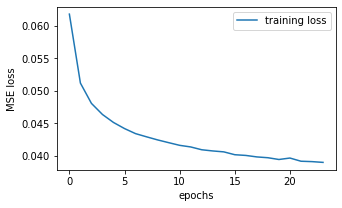

In [12]:
plt.figure(figsize=(5, 3))

epochs = [x[0] for x in outputs_l]
train_loss = [x[3] for x in outputs_l]

plt.plot(epochs, train_loss, label="training loss")
plt.xlabel("epochs")
plt.ylabel("MSE loss")
plt.legend()
plt.savefig('figures/AE_linear_loss.pdf', format='pdf', bbox_inches='tight')
#plt.show()

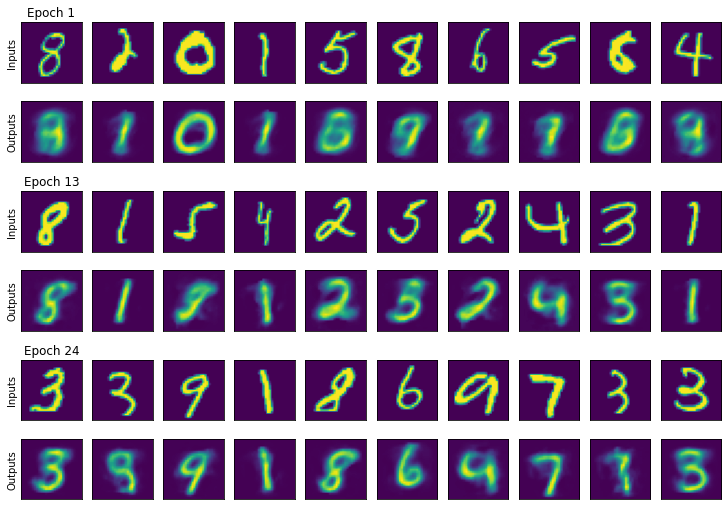

In [13]:
fig, axs = plt.subplots(6, 10, 
                        figsize=(10, 7), 
                        layout="constrained",
                        gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

for i, k in enumerate([0, num_epochs//2, num_epochs-1]):

    inputs = outputs_l[k][1].detach().numpy()
    outputs = outputs_l[k][2].detach().numpy()

    axs[2*i, 0].set_title(f"Epoch {k+1}")
    axs[2*i, 0].set_ylabel("Inputs")

    for j, item in enumerate(inputs):

        if j >= 10: break
        item = item.reshape(-1, 28,28) # for Autoencoder_Linear
        axs[2*i, j].imshow(item[0])
        axs[2*i, j].set_xticks([])
        axs[2*i, j].set_yticks([])

    axs[2*i + 1, 0].set_ylabel("Outputs")
    for j, item in enumerate(outputs):

        if j >= 10: break
        item = item.reshape(-1, 28,28) # for Autoencoder_Linear
        axs[2*i + 1, j].imshow(item[0])
        axs[2*i + 1, j].set_xticks([])
        axs[2*i + 1, j].set_yticks([])

fig.savefig('figures/AE_linear.pdf', format='pdf', bbox_inches='tight')
plt.show()

## 3. AE with convolutional layers

### Model

The following class implements an **autoencoder (AE)** composed of **convolutional layers**.

- Understand the architecture of this **autonecoder (AE)**.

In [14]:
class Autoencoder_CNN(nn.Module):
    """Implements a CNN autoencoder"""

    def __init__(self):
        """constructor"""

        super().__init__()

        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            # -> N, 16, 14, 14
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            # -> N, 32, 7, 7
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            # -> N, 64, 1, 1
            nn.Conv2d(32, 64, 7)
            )

        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            # -> N, 32, 7, 7
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            # N, 16, 14, 14 (N, 16, 13, 13 without output_padding)
            nn.ConvTranspose2d(32, 16, 3, 
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            # N, 1, 28, 28 (N,1, 27, 27)
            nn.ConvTranspose2d(16, 1, 3, 
                               stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
            )

    def forward(self, x):
        """forward function"""

        encoded_data = self.encoder(x)
        decoded_data = self.decoder(encoded_data)

        return decoded_data


# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

### Training

- Define a **loss** (`MSEloss`) and an **optimizer** (`torch.optim.Adam`) with learning rate `lr=1e-3` for this model.

- Implement a **training loop** for this model during $12$ epochs. During training, after each epoch, store the current `epoch`, `inputs`, `outputs` and `train_loss` of the model (in this order) in a list called `outputs_l`.

In [ ]:
model_2 = Autoencoder_CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_2.parameters(), 
                             lr=1e-3, 
                             weight_decay=1e-5)

In [16]:
num_epochs = 12
outputs_l = []

for epoch in range(num_epochs):

    train_loss = []

    for (inputs, _) in train_loader:

        # inputs = inputs.reshape(-1, 28*28) # reshape data 28 x 28 -> 784
        outputs = model_2(inputs)

        loss = criterion(outputs, inputs)
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = torch.mean(torch.tensor(train_loss)).item()

    print(f'Epoch:{epoch+1} \t Train loss: {train_loss:.4f}')

    outputs_l.append((epoch, inputs, outputs, train_loss))

Epoch:1 	 Train loss: 0.0398
Epoch:2 	 Train loss: 0.0081
Epoch:3 	 Train loss: 0.0053
Epoch:4 	 Train loss: 0.0042
Epoch:5 	 Train loss: 0.0037
Epoch:6 	 Train loss: 0.0033
Epoch:7 	 Train loss: 0.0031
Epoch:8 	 Train loss: 0.0030
Epoch:9 	 Train loss: 0.0029
Epoch:10 	 Train loss: 0.0029
Epoch:11 	 Train loss: 0.0028
Epoch:12 	 Train loss: 0.0028


### Results

- Plot the training loss to confirm that the model has been trained.

- Run the following code which displays the inputs and their reconstructions by the autoencoder at epochs $1$, $7$ and $12$. The reconstructions should improve as the epochs increase.

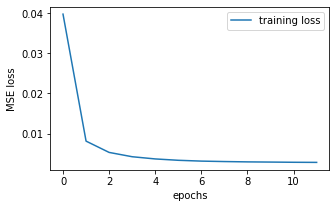

In [17]:
plt.figure(figsize=(5, 3))

epochs = [x[0] for x in outputs_l]
train_loss = [x[3] for x in outputs_l]

plt.plot(epochs, train_loss, label="training loss")
plt.xlabel("epochs")
plt.ylabel("MSE loss")
plt.legend()
plt.savefig('figures/AE_cnn_loss.pdf', format='pdf', bbox_inches='tight')
#plt.show()

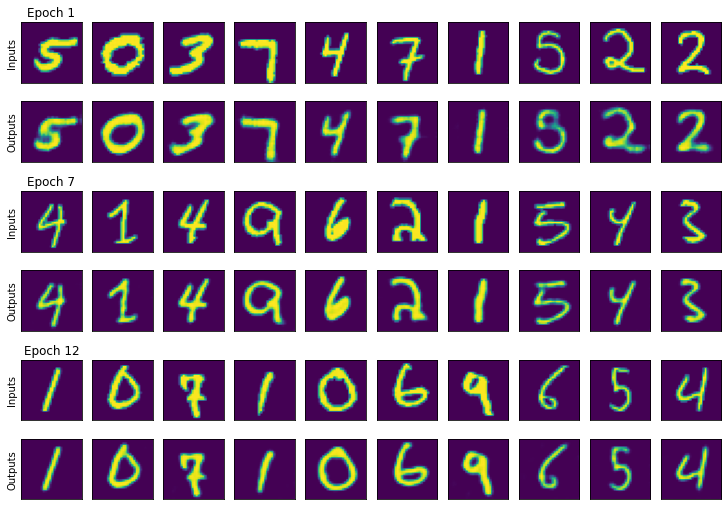

In [18]:
fig, axs = plt.subplots(6, 10, 
                        figsize=(10, 7), 
                        layout="constrained",
                        gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

for i, k in enumerate([0, num_epochs//2, num_epochs-1]):

    inputs = outputs_l[k][1].detach().numpy()
    outputs = outputs_l[k][2].detach().numpy()

    axs[2*i, 0].set_title(f"Epoch {k+1}")
    axs[2*i, 0].set_ylabel("Inputs")

    for j, item in enumerate(inputs):

        if j >= 10: break
        axs[2*i, j].imshow(item[0])
        axs[2*i, j].set_xticks([])
        axs[2*i, j].set_yticks([])

    axs[2*i + 1, 0].set_ylabel("Outputs")
    for j, item in enumerate(outputs):

        if j >= 10: break
        axs[2*i + 1, j].imshow(item[0])
        axs[2*i + 1, j].set_xticks([])
        axs[2*i + 1, j].set_yticks([])

fig.savefig('figures/AE_cnn.pdf', format='pdf', bbox_inches='tight')
# plt.show()

## 4. Visualizing the latent space

- Select about 1000 input images, about 100 samples of each input digit (0, 1, 2, ..., 9) (around 1000 / 64 = 16 batches), from your dataset.

- Compute the **encodings** of these samples in the **2D latent space**. For this purpose, note that the **encoder** part of the **autoencoder** `model` can be selected using tthe following instruction: `encoder = model.encoder.eval()`

- Plot the encoded data in the 2D latent space with their original labels in different colors. This will give you an idea of how the different data are distributed in the latent sapce.

In [19]:
# torch.save(model_1.state_dict(), "data/AE_linear.pt")

In [20]:
model_1 = Autoencoder_Linear()
model_1.load_state_dict(torch.load("data/AE_linear.pt"))
model_1.eval()

Autoencoder_Linear(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [21]:
encoder = model_1.encoder.eval()
encoder

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=12, bias=True)
  (5): ReLU()
  (6): Linear(in_features=12, out_features=2, bias=True)
)

In [22]:
nb_batches = 16
data_d = {"images" : [], "labels" : []}

for i, batch in enumerate(train_loader):
    
    with torch.no_grad():
        
        images, labels = batch[0], batch[1]
        images = images.reshape(-1, 28*28)

        encoded_images = encoder(images)

        if i == nb_batches:
            break
        else:
            data_d["images"].extend(encoded_images)
            data_d["labels"].extend(labels)

In [23]:
nb_images = len(data_d["images"])
nb_labels = len(data_d["labels"])

print(f"Nb of encoded images: {nb_images}")
print(f"Nb of labels: {nb_labels}")

Nb of encoded images: 1024
Nb of labels: 1024


In [24]:
latent_images = torch.cat(data_d["images"], axis=0).reshape(-1, 2)
labels = torch.tensor(data_d["labels"])

latent_images.shape, labels.shape

(torch.Size([1024, 2]), torch.Size([1024]))

In [25]:
for i in range(10):
    print((labels==i).sum())

tensor(92)
tensor(106)
tensor(115)
tensor(91)
tensor(100)
tensor(100)
tensor(109)
tensor(81)
tensor(117)
tensor(113)


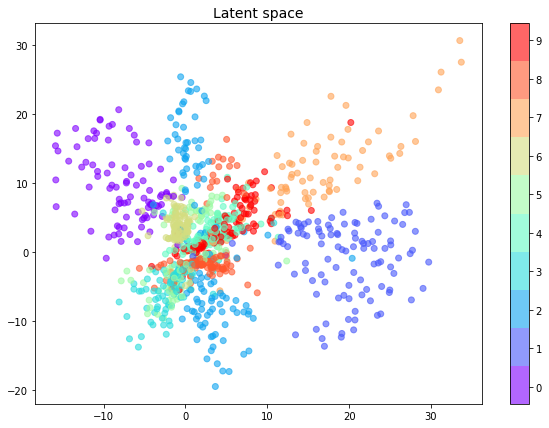

In [26]:
import numpy as np

x = latent_images[:, 0]
y = latent_images[:, 1]

plt.figure(figsize=(10, 7))
plt.title("Latent space", size=14)

cm = plt.cm.get_cmap('rainbow', 10)

plt.scatter(x, y, c=labels, alpha=0.6, cmap=cm)

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(0.4, 8.6, 10))
cbar.set_ticklabels(list(range(0, 10)))

plt.savefig('figures/AE_latent_space.pdf', format='pdf', bbox_inches='tight')
# plt.show()

## 5. Generative capabilities of the decoder

### 5.1: Uniform sampling from the latent space

- By considering the 1000 encoded data of the preovous exercice, estimate the minimal and maximal coordinates $x$ and $y$ of your encoded data in the 2D-latent space ($x_{min}$, $x_{max}$, $y_{min}$, $y_{max}$).

- Sample 100 2D-points from the latent space according to the uniform distribution $\mathcal{U}([x_{min}, x_{max}], [y_{min}, y_{max}])$.<br>
For this purpose, you can use the instruction:<br> 
`np.random.uniform(low=xy_min, high=xy_max, size=(100,2))`

- Compute the **decoded images** of these 2D-points. For this purpose, note that the **decoder** part of the **autoencoder** `model` can be selected using tthe following instruction: `decoder = model.decoder.eval()`. Store these images in a list called `decoded_samples`.

- At this stage, you have **generated** new images by *sampling* the 2D-latent space and *decoding* these samples. Plot these decoded images. Are these images of good quality? Do they resemble to the digits of the dataset?

In [27]:
import numpy as np

In [28]:
decoder = model_1.decoder.eval()
decoder

Sequential(
  (0): Linear(in_features=2, out_features=12, bias=True)
  (1): ReLU()
  (2): Linear(in_features=12, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=784, bias=True)
  (7): Sigmoid()
)

In [29]:
minx, maxx = min(x).item(), max(x).item()
miny, maxy = min(y).item(), max(y).item()

minx, maxx, miny, maxy

(-15.887487411499023,
 33.716094970703125,
 -19.518972396850586,
 30.696983337402344)

In [30]:
# Sample from a uniform distribution on the latent space
xy_min = [minx, miny]
xy_max = [maxx, maxy]

samples_uniform = np.random.uniform(low=xy_min, high=xy_max, size=(100,2))
samples_uniform = torch.tensor(samples_uniform).float()

In [31]:
samples_uniform.shape

torch.Size([100, 2])

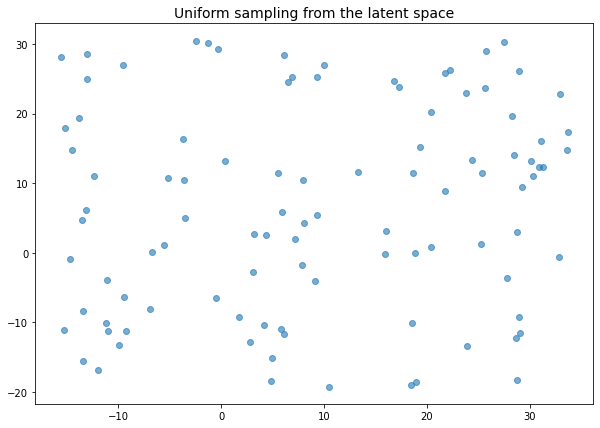

In [32]:
x = samples_uniform[:, 0]
y = samples_uniform[:, 1]

plt.figure(figsize=(10, 7))
plt.title("Uniform sampling from the latent space", size=14)

cm = plt.cm.get_cmap('rainbow', 10)

plt.scatter(x, y, alpha=0.6)

plt.savefig('figures/AE_uniform_sampling.pdf', format='pdf', bbox_inches='tight')
# plt.show()

In [33]:
with torch.no_grad():
    decoded_samples = decoder(samples_uniform)

decoded_samples = decoded_samples.reshape(100, 28, 28)
decoded_samples.shape

torch.Size([100, 28, 28])

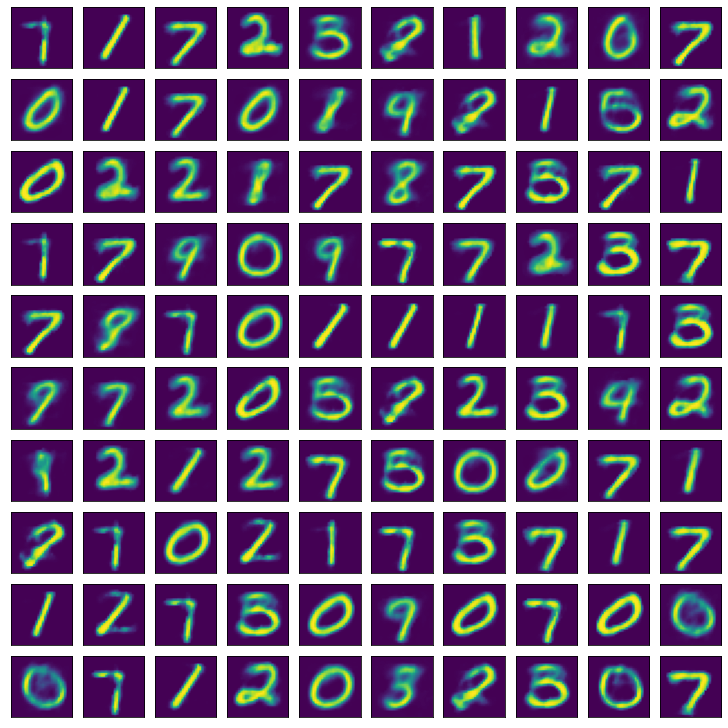

In [34]:
fig, axs = plt.subplots(10, 10, 
                        figsize=(10, 10), 
                        layout="constrained",
                        gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

for i in range(10):
    
    samples = decoded_samples[10*i:10*i+10, :, :]
    
    for j in range(10):
    
        axs[i, j].imshow(samples[j, :, :])
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])


fig.savefig('figures/AE_generator_uniform.pdf', format='pdf', bbox_inches='tight')
# plt.show()

### 5.2 Normal sampling from the latent space

- By considering the 1000 encoded data of the preovous exercice, estimate the mean $\mu$ and variance $\sigma^2$ of your encoded data in the 2D-latent space.

- Sample 100 2D-points from the latent space according to the normal distribution $\mathcal{UN}(\mu, \sigma^2)$.<br>
For this purpose, you can use the instruction:<br> 
`np.random.multivariate_normal(mean, cov, (100))`<br>
where `cov` is the diagonal matrix where the diagonal is the variance vector.

- Compute the **decoded images** of these 2D-points. For this purpose, note that the **decoder** part of the **autoencoder** `model` can be selected using tthe following instruction: `decoder = model.decoder.eval()`. Store these images in a list called `decoded_samples`.

- At this stage, you have **generated** new images by *sampling* the 2D-latent space and *decoding* these samples. Plot these decoded images. Are these images of good quality? Do they resemble to the digits of the dataset?

In [35]:
# Sample from a normal distribution on the latent space
mean = torch.mean(latent_images, axis=0)
std = torch.std(latent_images, axis=0)
cov = torch.diag(std)**2

samples_normal = np.random.multivariate_normal(mean, cov, (100))
samples_normal = torch.tensor(samples_normal).float()
samples_normal.shape

torch.Size([100, 2])

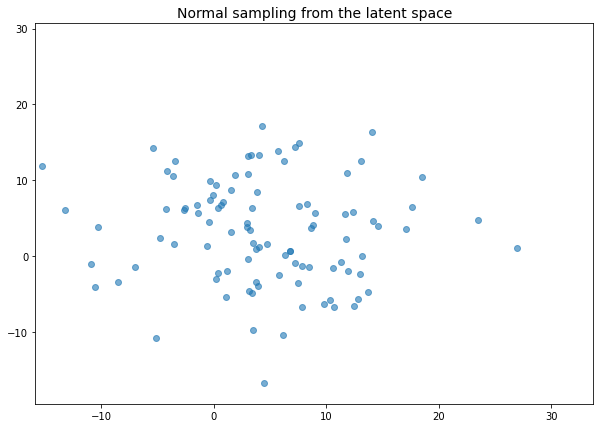

In [36]:
x = samples_normal[:, 0]
y = samples_normal[:, 1]

plt.figure(figsize=(10, 7))
plt.title("Normal sampling from the latent space", size=14)

cm = plt.cm.get_cmap('rainbow', 10)

plt.scatter(x, y, alpha=0.6)

plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

plt.savefig('figures/AE_normal_sampling.pdf', format='pdf', bbox_inches='tight')
# plt.show()

In [37]:
with torch.no_grad():
    decoded_samples = decoder(samples_normal)

decoded_samples = decoded_samples.reshape(100, 28, 28)
decoded_samples.shape

torch.Size([100, 28, 28])

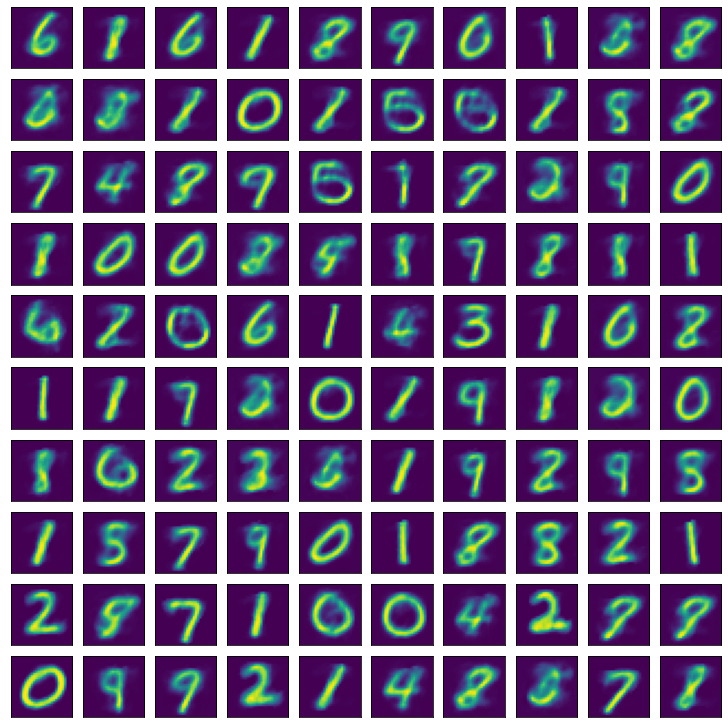

In [38]:
fig, axs = plt.subplots(10, 10, 
                        figsize=(10, 10), 
                        layout="constrained",
                        gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

for i in range(10):
    
    samples = decoded_samples[10*i:10*i+10, :, :]
    
    for j in range(10):
    
        axs[i, j].imshow(samples[j, :, :])
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])


fig.savefig('figures/AE_generator_normal.pdf', format='pdf', bbox_inches='tight')
# plt.show()

**Conclusion:** In both cases, the generated data are somewhat blurry and some numbers are over-represented.